# Assignment 1

# 1. Download  Data

# 2. Load and Explore data

In [1]:
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import export_graphviz
from scipy.stats import norm
from scipy.stats import truncnorm

import datetime                                               
import h2o                                                    
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  
from h2o.grid.grid_search import H2OGridSearch                
from interpret import show                                    
from interpret.glassbox import ExplainableBoostingClassifier  
from interpret.perf import ROC                                
import itertools                                              
import matplotlib.pyplot as plt                               
import numpy as np                                                                        
import time                                                   
import pandas as pd
import seaborn as sns
import xgboost as xgb                                         

# set numpy random seed for better reproducibility
SEED = 12345 

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators    


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+8-b765.1); OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from /Applications/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/3m/f_krj6ss7050n8pb8qp4g58r0000gn/T/tmpl5whw4cy
  JVM stdout: /var/folders/3m/f_krj6ss7050n8pb8qp4g58r0000gn/T/tmpl5whw4cy/h2o_chengshuyang_started_from_python.out
  JVM stderr: /var/folders/3m/f_krj6ss7050n8pb8qp4g58r0000gn/T/tmpl5whw4cy/h2o_chengshuyang_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       America/Chicago
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.32.1.3
H2O_cluster_version_age:    10 days
H2O_cluster_name:           H2O_from_python_chengshuyang_0topwn
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.8.8 final
--------------------------  ------------------------------------------------------------------

### Start global timer

In [2]:
tic = time.time()

### Import data

In [3]:
training = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

In [4]:
# Assign modeling roles
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

## Data exploration

### Profile report

In [5]:
report = ProfileReport(training)
report

Summarize dataset:   0%|          | 0/36 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Histogram

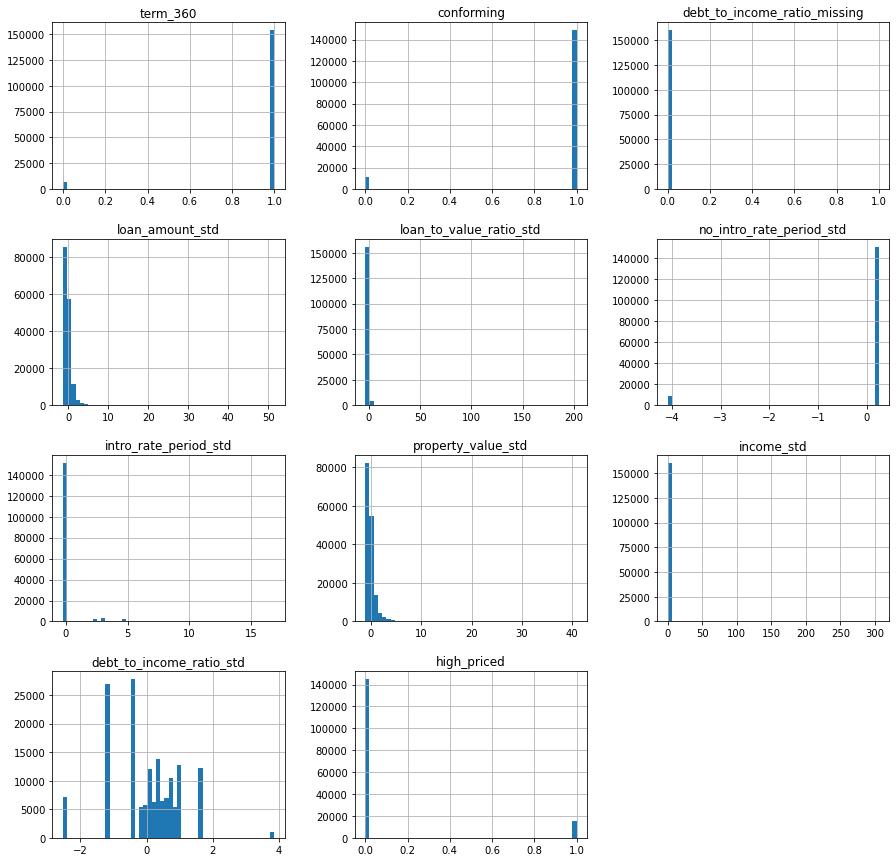

In [6]:
_ = training[x_names + [y_name]].hist(bins=50, figsize=(15, 15))

### Correlation

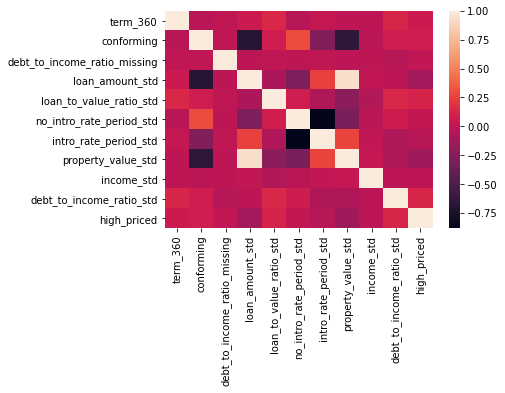

In [7]:
corr = training[x_names + [y_name]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

# 3. Train Interpretable Models

### Split data into train and validation parts

In [8]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(training)) < split_ratio
train = training[split]
validation = training[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (validation.shape[0], validation.shape[1]))

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


## 3.1 Decision Tree

In [9]:
# preserve exact reproducibility for this cell
np.random.seed(SEED) 
x = training[x_names]
y = training[y_name]
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size = 0.2,random_state = 100)

In [10]:
decision_tree = DecisionTreeClassifier(max_depth = 5, random_state = 200)
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=200)

In [11]:
tree_train_preds = decision_tree.predict(x_train)
accuracy_score(tree_train_preds, y_train)

0.9031807905199969

In [12]:
tree_valid_preds = decision_tree.predict(x_valid)
accuracy_score(tree_valid_preds, y_valid)

0.9040476487464139

In [13]:
roc_auc_score(y_valid, tree_valid_preds)

0.5004528347813691

In [14]:
def feature_importance(m, xs):
    '''Return a DataFrame of a model's feature importances in descending order'''
    return pd.DataFrame({'cols':xs.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [15]:
def plot_fi(fi):
    '''Plot feature importances'''
    return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False);

<AxesSubplot:ylabel='cols'>

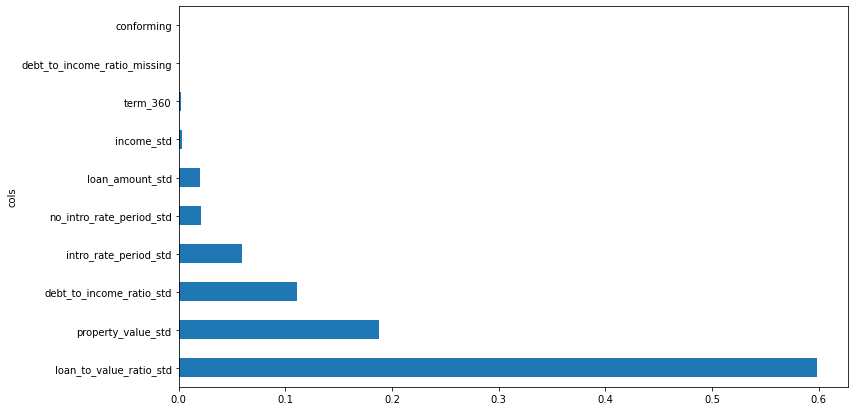

In [16]:
fi_1 = feature_importance(decision_tree, x_valid)
plot_fi(fi_1)

In [17]:
predicts1 = decision_tree.predict(test[x_names])
print(predicts1)

[0 0 0 ... 0 0 0]


In [18]:
probability1 = decision_tree.predict_proba(test[x_names])
print(probability1)

[[0.96735187 0.03264813]
 [0.96735187 0.03264813]
 [0.83342917 0.16657083]
 ...
 [0.81222788 0.18777212]
 [0.98295858 0.01704142]
 [0.7411023  0.2588977 ]]


In [19]:
phat_0_m1 = []
phat_1_m1 = []
for i in probability1:
    phat_0_m1.append(i[0])
    phat_1_m1.append(i[1])

In [20]:
model1 = pd.DataFrame(columns = ["phat_0", "phat_1"])
model1["phat_0"] = phat_0_m1
model1["phat_1"] = phat_1_m1
model1.to_csv('group_3_decision_tree' + '.csv', index=False)

## 3.2 Random Forest

In [21]:
forest = RandomForestClassifier(n_estimators = 5, max_depth = 5, random_state = 100)
forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=5, random_state=100)

In [22]:
forest_train_preds = forest.predict(x_train)
accuracy_score(forest_train_preds, y_train)

0.9031184220784283

In [23]:
forest_valid_preds = forest.predict(x_valid)
accuracy_score(forest_valid_preds, y_valid)

0.9040164650118498

<AxesSubplot:ylabel='cols'>

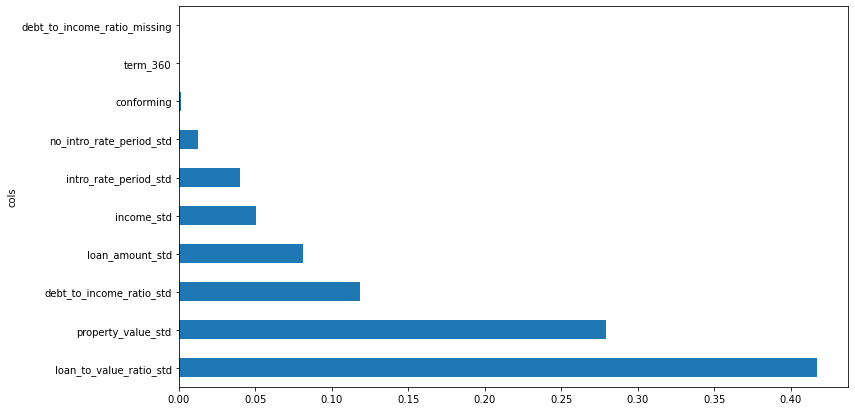

In [24]:
fi_2 = feature_importance(forest, x_valid)
plot_fi(fi_2)

In [25]:
predicts2 = forest.predict(test[x_names])
print(predicts1)

[0 0 0 ... 0 0 0]


In [26]:
probability2 = forest.predict_proba(test[x_names])
print(probability2)

[[0.93697168 0.06302832]
 [0.96965227 0.03034773]
 [0.82569119 0.17430881]
 ...
 [0.82517302 0.17482698]
 [0.96472427 0.03527573]
 [0.7540982  0.2459018 ]]


In [27]:
phat_0_m2 = []
phat_1_m2 = []
for i in probability2:
    phat_0_m2.append(i[0])
    phat_1_m2.append(i[1])

In [28]:
model2 = pd.DataFrame(columns = ["phat_0", "phat_1"])
model2["phat_0"] = phat_0_m2
model2["phat_1"] = phat_1_m2
model2.to_csv('group_3_random_forest' + '.csv', index=False)

## 3.3 Elastic Net Logistic Regression Using H2o

#### Define wrapper function for grid search

In [29]:
def glm_grid(x_names, y_name, htrain, hvalid, seed):

    """ Wrapper function for penalized GLM with alpha and lambda search.

    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame.
    :param seed: Random seed for better reproducibility.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    alpha_opts = [0.01, 0.25, 0.5, 0.99]  # always keep some L2

    # define search criteria
    # i.e., over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family='binomial',
                                      lambda_search=True,
                                      seed=seed), # seed for grid search
        hyper_params=hyper_parameters)

    # execute training w/ grid search
    grid.train(y=y_name,
               x=x_names,
               training_frame=htrain,
               validation_frame=hvalid,
               seed=seed) # seed for training

    # select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

#### Fit elastic net with grid search

In [30]:
# start local timer
glm_tic = time.time()

# convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(validation)

# train with grid search
best_glm = glm_grid(x_names, y_name, htrain, hvalid, SEED)

# end local timer
glm_toc = time.time() - glm_tic
print('Elastic net GLM training completed in %.2f s.' % (glm_toc))

Elastic net GLM training completed in 15.33 s.


#### AUC assessment

In [31]:
print('Validation AUC: %.4f.' % best_glm.auc(valid=True))

Validation AUC: 0.7538.


#### Write submission file

In [32]:
best_glm_submit = best_glm.predict(h2o.H2OFrame(test)).as_data_frame() 
best_glm_submit.drop(['predict', 'p0'], axis=1, inplace=True)
best_glm_submit.columns = ['phat']
best_glm_submit.to_csv('group_3_elastic_net' + '.csv', index=False)

## 3.4 Monotonic GBM Using XGBoost

#### Define utility function for random grid search

In [33]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

#### Fit monotonic XGBoost with random grid search

In [34]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[x_names], train[y_name])
dvalid = xgb.DMatrix(validation[x_names], validation[y_name])

# Monotonic XGBoost grid search
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0}
Grid search new best score discovered at iteration 1/50: 0.7910.
---------- ----------
Grid search run 2/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 3/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree'

Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 21/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 22/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel':

---------- ----------
Grid search run 40/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.3, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 41/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 42/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, '

#### AUC assessment

In [35]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7921.


#### Write submission file

In [36]:
dtest = xgb.DMatrix(test[x_names])
best_mxgb_submit = pd.DataFrame(best_mxgb.predict(dtest, ntree_limit=best_mxgb.best_ntree_limit), columns=['phat'])
best_mxgb_submit.to_csv('group_3_monotonic_gbm' + '.csv', index=False)

## 3.5 EBM Using Interpret

#### Define utility function for random grid search

In [37]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name]) 
        
        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del ebm
            
    return best_candidate

#### Fit EBM with random grid search

In [38]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(train, validation, x_names, y_name, gs_params=gs_params, n_models=10, 
                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.8217.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max

#### AUC assessment

In [39]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(validation[x_names], validation[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8247.


#### Write submission file

In [40]:
best_ebm_submit = pd.DataFrame(best_ebm.predict_proba(test[x_names])[:, 1], columns=['phat'])
best_mxgb_submit.to_csv('group_3_ebm' + '.csv', index=False)

### End global timer

In [42]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 1402.75 s.


### Shut Down h2o

In [43]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_b214 closed.
